In [1]:
!nvidia-smi

Mon Jan 19 23:15:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:E1:00.0 Off |                    0 |
| N/A   31C    P0             53W /  300W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import os
import numpy as np
import xarray as xr
import pickle
import glob
import warnings
from pathlib import Path, PureWindowsPath
import re

import cedalion
import cedalion.sigproc.motion as motion_correct
import cedalion.sigproc.quality as quality
import cedalion.sigproc.physio as physio
import cedalion.dot as dot
import cedalion.nirs as nirs
from cedalion.io.forward_model import load_Adot
from cedalion import units
import copy
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
def get_bad_ch_mask(int_data):
    # Saturated and Dark Channels

    dark_sat_thresh = [1e-3, 0.84]
    amp_threshs_sat = [0., dark_sat_thresh[1]]
    amp_threshs_low = [dark_sat_thresh[0], 1]
    _, amp_mask_sat = quality.mean_amp(int_data, amp_threshs_sat)
    _, amp_mask_low = quality.mean_amp(int_data, amp_threshs_low)
    _, snr_mask = quality.snr(int_data, 10)
    amp_mask=amp_mask_sat & amp_mask_low

    _, list_bad_ch = quality.prune_ch(int_data, [amp_mask, snr_mask], "all")
   
    return list_bad_ch

In [3]:
def standardize_trial_types(DATASET_NAME: str, file: str, rec):
    
    if DATASET_NAME == "FreshMotor":
        # map trial types to left or right depending on the name of the file
        m = re.search(r'(?i)(left|right)', file)

        # rename from MOTOR to left/right
        rec.stim.trial_type = m.group(1).lower()
    
    else:
        mapping = {
            "Right": "right", # BallSqueezingHD
            "Left": "left",   # BallSqueezingHD
            "ElectricalVAS7": "right", # TODO: Electrical_Thermal
            "ElectricalVAS3": "left",  # TODO: Electrical_Thermal
        }
        rec.stim["trial_type"] = rec.stim["trial_type"].replace(mapping)

    return rec

In [4]:
base_path = "/home/orabe/fNIRS_sparseToDense/"

# Available datasets:
# DATASET_NAME = "BallSqueezingHD_modified"
# DATASET_NAME = "FreshMotor"
DATASET_NAME = "BS_Laura"
# DATASET_NAME = "ElectricalThermal"

raw_path = Path(f'datasets/raw/{DATASET_NAME}')

pre_processed_path = Path(f'datasets/pre_processed/{DATASET_NAME}')
pre_processed_path.mkdir(parents=True, exist_ok=True)

In [5]:
if DATASET_NAME == "BallSqueezingHD_modified":
    raw_dir = f"{raw_path}/sub-*/nirs/sub-*.snirf"

elif DATASET_NAME == "BS_Laura":
    raw_dir = f"{raw_path}/sub-*/nirs/sub-*.snirf"
    
elif DATASET_NAME == "Electrical_Thermal":
    raw_dir = f"{raw_path}/sub-*/ses-*/nirs/sub-*_ses-*_task-Electrical*_nirs.snirf"
    # TODO: exclude subjects without txt files for landmarks coords
    
elif DATASET_NAME == "FreshMotor":
    duration = "*" # * to include both 2s and 3s
    raw_dir = f"{raw_path}/sub-*/ses-*{duration}/nirs/sub-*_ses-*{duration}_task-FRESHMOTOR_nirs.snirf"
else:
    raise ValueError("Unknown dataset name")

files = glob.glob(raw_dir)

# TODO: to be confirmed
# remove non-BS files for Laura's dataset to avoid errors
if DATASET_NAME == "BS_Laura":
    files = [p for p in files if "BS" in os.path.basename(p)]
    
files = sorted(files)
print(f"{len(files)} files found.")

63 files found.


In [6]:
filename = files[1] # select one
rec = cedalion.io.read_snirf(filename)[0]  # read snirf files
rec['amp']

Magnitude,[[[0.0021773733195343315 0.002159860588358232 0.002144665718661322 ... 0.0018875118645534468 0.0018545467235160827 0.0018032962308095557] [0.002821738810749057 0.002818648328776804 0.002830108866090575 ... 0.002711125310158839 0.002662063908849325 0.0025994816489112037]] [[0.00031007835788270566 0.00026127449673754555 0.00026758423076422855 ... 0.0002607594164088368 0.00029449717793926403 0.0002686143914216462] [0.000594016389083439 0.0005817832312766047 0.0005707090042093651 ... 0.0005561579849233413 0.0005803667603726555 0.0005811393808657187]] [[0.11490605127959475 0.11484475672047839 0.11499593279695443 ... 0.11423992364449208 0.11458167944259037 0.11514337454104734] [0.15292065354937348 0.15316261253378444 0.15364395510096285 ... 0.151739445585562 0.15230461747623772 0.1533328465824227]] ... [[0.00011254505182287572 0.00025277567131385016 0.00023036967701501676 ... 0.00022882443602889035 0.00020551705115481655 0.00024981395942377446] [0.00041026148181656986 0.000512376156983092 0.00048739476104071465 ... 0.0004861070602189426 0.0004956360463000556 0.0005094144450930164]] [[0.5536388558057087 0.5513941357331956 0.5492584839202866 ... 0.4652017524578024 0.4541924255119802 0.44467670274933135] [0.7458432695547994 0.7425284700993938 0.739191007109525 ... 0.6135644601784316 0.5979334462131873 0.5854578143416134]] [[1e-06 3.8631024653160986e-06 1e-06 ... 1e-06 1e-06 9.271445916758637e-06] [1e-06 7.211124601923366e-06 1.5452409861264394e-06 ... 7.726204930632197e-07 1e-06 1.1074227067239465e-05]]]
Units,dimensionless


In [7]:
filename

'datasets/raw/BS_Laura/sub-538/nirs/sub-538_task-BS_run-02_nirs.snirf'

In [8]:
filename = files[0] # select one
rec = cedalion.io.read_snirf(filename)[0]  # read snirf files
meas_list = rec._measurement_lists["amp"]

head_icbm152 = dot.get_standard_headmodel('icbm152')  

if DATASET_NAME == "BS_Laura":
    # this is required for BU Data (Laura's)
    T = np.array([
        [-9.57882733e-01, -7.20806358e-03,  6.20193531e-03, 2.21208571e+02],
        [-2.02271710e-02,  6.03819925e-02,  9.94046165e-01, -2.03010603e+01],
        [-8.79481533e-03, -1.02761992e+00,  6.59199998e-02, 2.87749135e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]])
    
    ninja_aligned = rec.geo3d.points.apply_transform(T)
    geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(ninja_aligned)
else:
    geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(rec.geo3d)

fwm = cedalion.dot.forward_model.ForwardModel(
    head_icbm152, 
    geo3d_snapped_ijk,
    meas_list
)

fluence_fname = os.path.join(pre_processed_path, "fluence_" + DATASET_NAME + ".h5")
sensitivity_fname = os.path.join(pre_processed_path, "sensitivity_" + DATASET_NAME + ".h5")

# compute fluence and sensitivity only once
# fwm.compute_fluence_mcx(fluence_fname)
# fwm.compute_sensitivity(fluence_fname, sensitivity_fname)

Adot = load_Adot(sensitivity_fname)

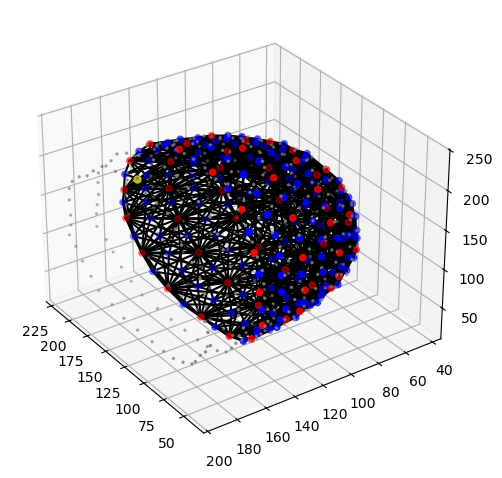

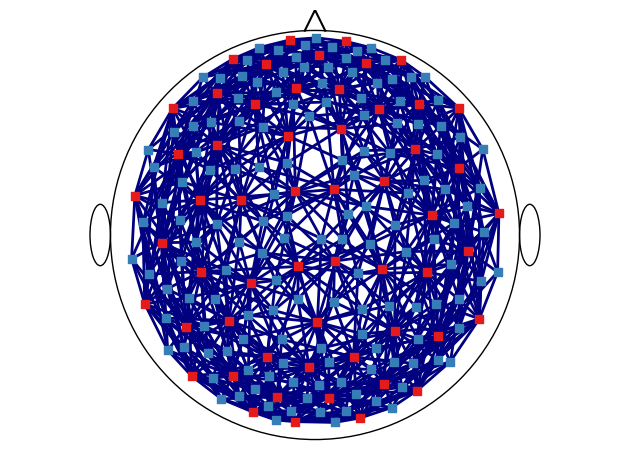

In [9]:
from cedalion.vis.anatomy import plot_montage3D

# use the plot_montage3D() function. It requires a recording container and a geo3d object
plot_montage3D(rec["amp"], rec.geo3d)

fig, ax = plt.subplots(1, 1)

cedalion.vis.anatomy.scalp_plot(
    rec['amp'],
    geo3d_snapped_ijk,
    np.ones(rec['amp'].channel.size),
    ax,
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
plt.tight_layout()

In [10]:
rec['amp'].shape

(1220, 2, 3241)

In [11]:
# build sensitivity once
parcel_dOD, parcel_mask = fwm.parcel_sensitivity(
    Adot,
    [],  # bad channels list
    dOD_thresh=0.001,
    minCh=1,
    dHbO=10,
    dHbR=-3
)

In [12]:
parcel_dOD.shape, parcel_mask.shape

((2, 1220, 602), (602,))

In [13]:
sens_parcel_yuanyuan_path = 'datasets/pre_processed/BallSqueezingHD_modified/parcel_template_BallSqueezingHD_modified.pkl'

with open(sens_parcel_yuanyuan_path, 'rb') as handle:
    template_sens_parcel_list = pickle.load(handle)

len(template_sens_parcel_list)

110

In [14]:
# keep only parcels that passed the mask
valid_parcels = parcel_mask.where(parcel_mask, drop=True).parcel
parcel_dOD_valid = parcel_dOD.sel(parcel=valid_parcels)
parcel_dOD_valid.shape

(2, 1220, 374)

In [15]:
# keep only parcels that are in the template list from Yuanyuan dataset (bsq-hd)
parcel_dOD_valid = parcel_dOD.sel(parcel=template_sens_parcel_list)
parcel_dOD_valid.shape

(2, 1220, 110)

In [16]:
parcel_dOD_valid

<xarray.DataArray (wavelength: 2, channel: 1220, parcel: 110)> Size: 2MB
array([[[3.49411362e-14, 1.86365999e-19, 3.90599330e-15, ...,
         8.54363437e-14, 2.69568197e-20, 3.04924852e-16],
        [1.45047269e-14, 2.79094069e-14, 3.88496807e-14, ...,
         1.24569107e-17, 3.41395966e-19, 1.56951805e-19],
        [3.17959395e-17, 5.30053795e-16, 1.28889941e-15, ...,
         1.46178690e-19, 4.62683159e-20, 3.45073957e-21],
        ...,
        [1.97043879e-10, 4.47852217e-10, 4.44245518e-10, ...,
         6.11209971e-17, 1.03206002e-16, 1.97644419e-15],
        [1.49666752e-11, 1.40375710e-11, 2.90788590e-11, ...,
         1.96698331e-17, 7.23339676e-18, 5.53137771e-17],
        [4.97030920e-11, 2.36652771e-10, 9.71037484e-11, ...,
         3.04774080e-17, 2.56085653e-15, 3.63195778e-16]],

       [[2.44730660e-13, 1.30532315e-18, 2.73579059e-14, ...,
         5.98403344e-13, 1.88807835e-19, 2.13571934e-15],
        [1.01592328e-13, 1.95479836e-13, 2.72106434e-13, ...,
         8.72492514e-17, 2.39116609e-18, 1.09930365e-18],
        [2.22701437e-16, 3.71254140e-15, 9.02755999e-15, ...,
         1.02384785e-18, 3.24067180e-19, 2.41692704e-20],
        ...,
        [1.38011192e-09, 3.13679463e-09, 3.11153301e-09, ...,
         4.28096609e-16, 7.22863528e-16, 1.38431815e-14],
        [1.04827853e-10, 9.83203289e-11, 2.03670776e-10, ...,
         1.37769167e-16, 5.06633199e-17, 3.87422352e-16],
        [3.48124641e-10, 1.65753593e-09, 6.80122829e-10, ...,
         2.13466332e-16, 1.79364547e-14, 2.54385380e-15]]],
      shape=(2, 1220, 110))
Coordinates:
  * channel     (channel) object 10kB 'S1D2' 'S1D33' ... 'S56D134' 'S56D135'
  * parcel      (parcel) object 880B 'ContA_IPS_2_LH' ... 'TempPar_8_LH'
  * wavelength  (wavelength) float64 16B 760.0 850.0

In [32]:
# parcel_dOD dims: (wavelength, channel, parcel)

# reduce sensitivity across wavelength and parcel
sens_strength = np.abs(parcel_dOD_valid).mean(dim="wavelength").max(dim="parcel")

# keep top 10% sensitivity channels
keep_ch = sens_strength > sens_strength.quantile(0.95)
keep_channels = sens_strength.channel.values[keep_ch]

rec_sub = copy.deepcopy(rec)

rec_sub["amp"] = rec["amp"].sel(channel=keep_channels)

# map to optodes (sources + detectors)
keep_sources = set(rec["amp"].source.sel(channel=keep_channels).values)
keep_detectors = set(rec["amp"].detector.sel(channel=keep_channels).values)
keep_optodes = list(keep_sources | keep_detectors)

rec_sub.geo3d = rec_sub.geo3d.sel(label=keep_optodes)

print("Kept channels:", len(rec_sub['amp'].channel))
print("Kept optodes:", len(rec_sub.geo3d.label))
print("Kept sources:", len(set(rec_sub['amp'].source.values)))
print("Kept detectors:", len(set(rec_sub['amp'].detector.values)))

Kept channels: 61
Kept optodes: 55
Kept sources: 18
Kept detectors: 37


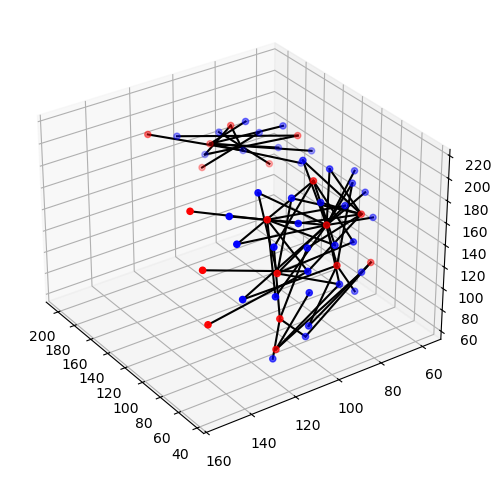

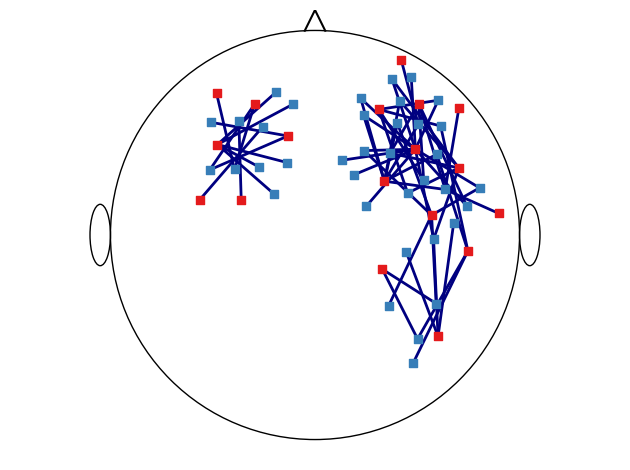

In [33]:
plot_montage3D(rec_sub['amp'], rec_sub.geo3d)

fig, ax = plt.subplots(1, 1)
cedalion.vis.anatomy.scalp_plot(
    rec_sub['amp'],
    geo3d_snapped_ijk,
    np.ones(rec_sub['amp'].channel.size),
    ax,
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
plt.tight_layout()

In [62]:
# Approach 2

In [34]:
# parcel_dOD dims: (wavelength, channel, parcel)
sens_strength = np.abs(parcel_dOD_valid).mean(dim="wavelength").max(dim="parcel")

# sort channels by sensitivity
sorted_idx = np.argsort(sens_strength.values)[::-1]
sorted_channels = sens_strength.channel.values[sorted_idx]
sorted_weights = sens_strength.values[sorted_idx]

# top N channels
N = 100
top_channels = sorted_channels[:N]
top_weights = sorted_weights[:N]

print(top_channels)


['S9D87' 'S10D107' 'S10D131' 'S14D92' 'S10D133' 'S56D8' 'S13D104' 'S16D85'
 'S9D112' 'S11D84' 'S10D83' 'S26D21' 'S12D87' 'S6D18' 'S10D132' 'S11D133'
 'S13D137' 'S20D90' 'S52D94' 'S25D17' 'S6D8' 'S22D104' 'S10D135' 'S13D96'
 'S10D95' 'S52D96' 'S15D85' 'S53D1' 'S52D141' 'S12D136' 'S52D92' 'S12D85'
 'S11D94' 'S26D22' 'S12D83' 'S11D128' 'S13D136' 'S26D130' 'S9D90' 'S26D20'
 'S46D79' 'S26D66' 'S20D89' 'S13D112' 'S56D3' 'S52D89' 'S22D111' 'S46D99'
 'S9D91' 'S52D135' 'S10D137' 'S20D79' 'S10D84' 'S22D82' 'S29D18' 'S10D141'
 'S10D104' 'S20D77' 'S52D85' 'S11D99' 'S10D91' 'S26D17' 'S11D136' 'S17D98'
 'S16D89' 'S26D23' 'S19D100' 'S17D76' 'S11D92' 'S11D97' 'S11D132'
 'S17D112' 'S22D128' 'S13D102' 'S11D88' 'S46D82' 'S52D82' 'S30D45'
 'S10D110' 'S35D11' 'S6D20' 'S6D22' 'S5D90' 'S22D83' 'S11D101' 'S13D94'
 'S20D112' 'S8D136' 'S13D100' 'S46D102' 'S10D82' 'S56D1' 'S25D1' 'S11D108'
 'S12D135' 'S17D77' 'S56D18' 'S23D99' 'S20D97' 'S20D86']


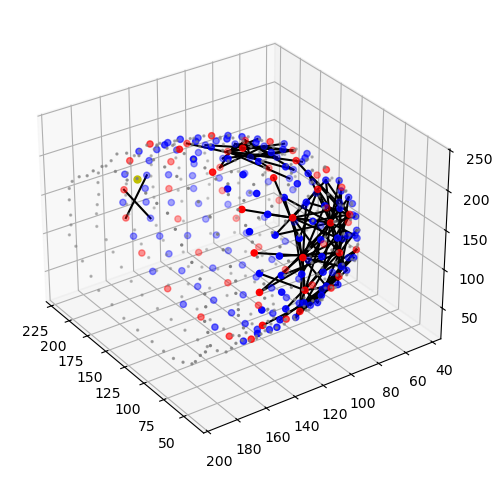

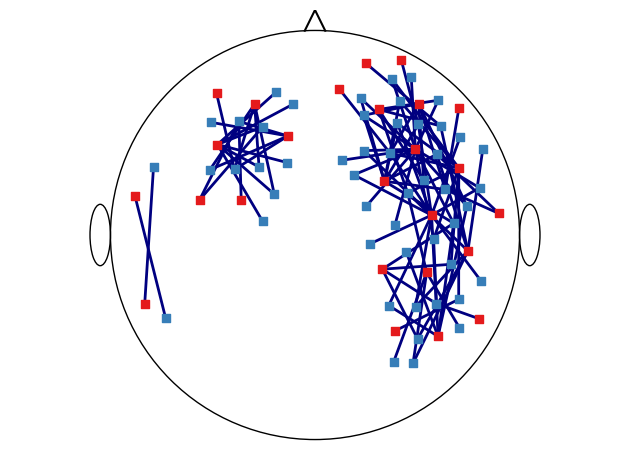

In [35]:
# plot after subsetting channels
rec_sub = copy.deepcopy(rec)
rec_sub['amp'] = rec['amp'].sel(channel=top_channels)

plot_montage3D(rec_sub['amp'], rec_sub.geo3d)


fig, ax = plt.subplots(1, 1)

cedalion.vis.anatomy.scalp_plot(
    rec_sub['amp'],
    geo3d_snapped_ijk,
    np.ones(rec_sub['amp'].channel.size),
    ax,
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
plt.tight_layout()